# 라이브러리 로딩


In [1]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from imblearn.over_sampling import ADASYN

import warnings
warnings.filterwarnings('ignore')

matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['axes.unicode_minus'] = False


# 시드 고정


In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


seed_everything(42)


# 데이터 불러오기


In [3]:
train = pd.read_csv('./dataset/train.csv')
test = pd.read_csv('./dataset/test.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30200 entries, 0 to 30199
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ID       30200 non-null  object 
 1   가입일      30200 non-null  int64  
 2   음성사서함이용  30200 non-null  int64  
 3   주간통화시간   30200 non-null  float64
 4   주간통화횟수   30200 non-null  int64  
 5   주간통화요금   30200 non-null  float64
 6   저녁통화시간   30200 non-null  float64
 7   저녁통화횟수   30200 non-null  int64  
 8   저녁통화요금   30200 non-null  float64
 9   밤통화시간    30200 non-null  float64
 10  밤통화횟수    30200 non-null  int64  
 11  밤통화요금    30200 non-null  float64
 12  상담전화건수   30200 non-null  int64  
 13  전화해지여부   30200 non-null  int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 3.2+ MB


In [5]:
display(train.head(2), test.head(2))


,ID,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수,전화해지여부
0,TRAIN_00000,329,0,99.2,93,27.3,268.8,68,28.92,262.9,328,32.89,2,0
1,TRAIN_00001,2,80,323.9,323,83.7,269.4,326,32.09,322.8,209,32.32,2,0


,ID,가입일,음성사서함이용,주간통화시간,주간통화횟수,주간통화요금,저녁통화시간,저녁통화횟수,저녁통화요금,밤통화시간,밤통화횟수,밤통화요금,상담전화건수
0,TEST_00000,110,0,210.7,142,35.6,205.9,93,17.43,120.9,111,5.37,2
1,TEST_00001,283,1,268.5,100,30.3,283.0,92,28.32,290.0,89,8.82,0


# 전처리

1. 이상치 처리
2. 정규화


## 1. 이상치 처리 (IQR Capping)

-   가입일, 음성사서함 이용 컬럼에 적용


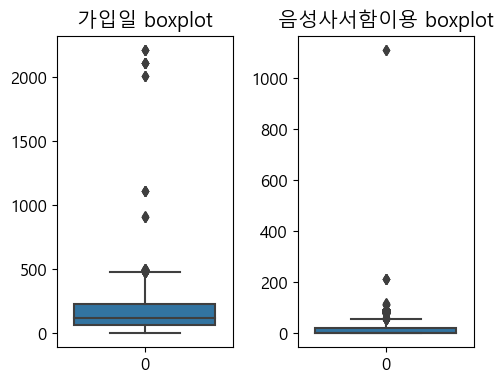

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(5, 4))
sns.boxplot(train['가입일'], ax=ax[0])
ax[0].set_title('가입일 boxplot')
sns.boxplot(train['음성사서함이용'], ax=ax[1])
ax[1].set_title('음성사서함이용 boxplot')
plt.tight_layout()
plt.show()


In [7]:
q1_1 = train['가입일'].quantile(.25)
q3_1 = train['가입일'].quantile(.75)
iqr_1 = q3_1 - q1_1

q1_2 = train['음성사서함이용'].quantile(.25)
q3_2 = train['음성사서함이용'].quantile(.75)
iqr_2 = q3_2 - q1_2


print('가입일 IQR : ', iqr_1)
print('음성사서함이용 IQR : ', iqr_2)

print('가입일 boxplot 최솟값-최댓값 범위 : ',
      0 if q1_1 - (iqr_1 * 1.5) <= 0 else q1_1 - (iqr_1 * 1.5), '~',
      q3_1 + (iqr_1 * 1.5))

print('음성사서함이용 boxplot 최솟값-최댓값 범위 : ',
      0 if q1_2 - (iqr_1 * 1.5) <= 0 else q1_2 - (iqr_2 * 1.5), '~',
      q3_2 + (iqr_2 * 1.5))


가입일 IQR :  165.0
음성사서함이용 IQR :  22.0
가입일 boxplot 최솟값-최댓값 범위 :  0 ~ 475.5
음성사서함이용 boxplot 최솟값-최댓값 범위 :  0 ~ 55.0


In [8]:
maximum_1 = q3_1 + (iqr_1 * 1.5)
maximum_2 = q3_2 + (iqr_2 * 1.5)

train.loc[train['가입일'] > maximum_1, '가입일'] = maximum_1
train.loc[train['음성사서함이용'] > maximum_2, '음성사서함이용'] = maximum_2


## 2. 정규화 (MinMaxScaling)

- 독립변수(x_train), 종속변수(y_train)로 나누고 x_train, test에 적용


In [9]:
# 예측에 도움이 될 수 없는 ID 컬럼, 종속변수 제거
x_train = train.drop(['ID', '전화해지여부'], axis=1)
# 종속변수 설정
y_train = train['전화해지여부']
# 예측에 도움이 될 수 없는 ID 컬럼 제거
test = test.drop('ID', axis=1)

In [10]:
minmax = MinMaxScaler()

x_train = pd.DataFrame(minmax.fit_transform(x_train), columns=x_train.columns)
test = pd.DataFrame(minmax.transform(test), columns=test.columns)


# 모델 정의


In [11]:
# rfc = RandomForestClassifier(max_features='auto', n_jobs=-1, random_state=42)
# lgbm = LGBMClassifier(random_state=42, is_unbalance=True)
xgb = XGBClassifier(random_state=42)
# cat = CatBoostClassifier(random_state=42)

# params_rfc = {
#     'n_estimators': [10, 50, 100, 200],
#     'criterion': ['gini', 'entropy', 'log_loss'],
#     'max_depth': [None, 4, 5, 6],
#     'class_weight': [None, 'balanced', 'balanced_subsample']
# }
# params_lgbm={
#     'boosting_type':['gbdt','dart'],
#     'max_depth':[-1,4,5,6],
#     'learning_rate':[.1,.01,.001],
#     'n_estimators':[10,50,100],
#     'class_weight':[None,'balanced']
# }
params_xgb={
    'booster':['gbtree','gblinear'],
    'learning_rate':[.1,.01],
    'scale_pos_weight':[1,8.1],
    'max_depth':[5,6,7,8],
    'n_estimators':[10, 50, 100, 200]
}
# params_cat = {
#     'learning_rate': [.1, .01, .5],
#     'n_estimators': [10, 50, 100, 200],
#     'scale_pos_weight': [1, 8.1]
# }

cv = GridSearchCV(estimator=xgb, param_grid=params_xgb, scoring='f1_macro', verbose=0)

cv.fit(x_train, y_train)


[04:34:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[04:34:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[04:34:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[04:34:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[04:34:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-08de971ced8a8cdc6-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_depth" } are not used.

[04:3

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             param_grid={'booster': ['gbtree', 'gblinear'],
                         'learning_rate': [0.1, 0.01],
                         'max_depth': [5, 6, 7, 8],
                         'n_estimators': [10, 50, 100, 200],
                         'scale_pos_weight': [1, 8.1]},
             scoring='f1_macro')

In [12]:
# GridSearchCV 확인용
xgb_result = pd.DataFrame(cv.cv_results_)

In [13]:
cv.best_params_

{'booster': 'gbtree',
 'learning_rate': 0.1,
 'max_depth': 8,
 'n_estimators': 200,
 'scale_pos_weight': 8.1}

In [17]:
xgb_model = XGBClassifier(booster='gbtree',learning_rate=.1, max_depth=8, n_estimators=200, scale_pos_weight=8.1, random_state=42)
xgb_model.fit(x_train, y_train, eval_metric='auc')

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [18]:
xgb_model.fit(x_train, y_train)

pred = xgb_model.predict(test)
submit = pd.read_csv('./dataset/sample_submission.csv')
submit['전화해지여부'] = pred
submit.to_csv('./final_submit.csv', index=False)